In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import importlib
from scipy.stats import randint, expon, uniform

import sklearn as sk
from sklearn import svm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn import preprocessing
from sklearn import pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold, RandomizedSearchCV

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process.kernels import RBF

from LoadData import load_data
import PlottingHelpers
import ProcessingHelpers

importlib.reload(ProcessingHelpers) # while still working on than fun
importlib.reload(PlottingHelpers) # while still working on than fun

In [29]:
sns.set() 

In [30]:
dirname = os.getcwd()
pth = os.path.join(dirname, 'CMAPSSData')

print('loading data...')
dc = load_data(pth)
print('done')

loading data...
done


In [31]:
# get the first data set training data
df = dc['FD_001']['df_train'].copy()

# Make a Column for the RUL target data (y)

According to the data description document the data set contains multiple units, each unit starts at a certain degradation point and the measurement data ends closely before the unit was decommissioned of broke. 

Therefore assume, that for the last measurement time that is available for a unit the units RUL=0 (stopped measuring just before machine broke)


In [32]:
# get the time of the last available measurement for each unit
mapper = {}
for unit_nr in df['unit_nr'].unique():
    mapper[unit_nr] = df['time'].loc[df['unit_nr'] == unit_nr].max()
    
# calculate RUL = time.max() - time_now for each unit
df['RUL'] = df['unit_nr'].apply(lambda nr: mapper[nr]) - df['time']

## Drop the nan columns and rows

In [33]:
cols_nan = df.columns[df.isna().any()].tolist()
print('Columns with all nan: \n' + str(cols_nan) + '\n')

cols_const = [ col for col in df.columns if len(df[col].unique()) <= 2 ]
print('Columns with all const values: \n' + str(cols_const) + '\n')

Columns with all nan: 
['sensor_22', 'sensor_23', 'sensor_24', 'sensor_25', 'sensor_26']

Columns with all const values: 
['os_3', 'sensor_01', 'sensor_05', 'sensor_06', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19', 'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25', 'sensor_26']



In [34]:
df = df.drop(columns=cols_const + cols_nan)

## Normalize the dataset as shown in the Explorative_analysis notebook

In [35]:
df_start = df.loc[df['time'] < 10.0].copy()
cols_non_data = [col for col in df.columns if not col.startswith('sens')]
bias = df_start.mean()
scale = df_start.var()

bias[cols_non_data] = 0.0
scale[cols_non_data] = 1.0

df_n = (df - bias) / scale
#df_n = df.copy()

take out a certain percentage of units from the training data set for testing later, (additionally to the classic validation methods)


In [36]:
units = df_n['unit_nr'].unique()
n_units = len(df_n['unit_nr'].unique())

units_test = random.sample(list(units), int(n_units * 0.2))
units_train = [nr for nr in units if nr not in units_test]

df_n_test = df_n.loc[df_n['unit_nr'].apply( lambda x: x in units_test )].copy()
df_n_train = df_n.loc[df_n['unit_nr'].apply( lambda x: x in units_train )].copy()

Get the training data and shuffle if to break the time dependency

In [37]:
df_n_train.describe()

,unit_nr,time,os_1,os_2,sensor_02,sensor_03,sensor_04,sensor_07,sensor_08,sensor_09,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21,RUL
count,16680.000000,16680.000000,16680.000000,16680.000000,16680.000000,16680.000000,16680.000000,16680.000000,16680.000000,16680.000000,16680.000000,16680.000000,16680.000000,16680.000000,16680.000000,16680.000000,16680.000000,16680.000000,16680.000000
mean,52.144125,110.496703,-0.000012,0.000001,2.210898,0.176856,0.185875,-1.518181,12.971974,0.134629,6.280476,-1.974325,13.505583,0.104750,34.455018,0.733743,-7.144203,-11.344421,109.496703
std,28.353436,70.458168,0.002188,0.000294,3.523610,0.284862,0.257756,2.188475,23.217422,0.311198,8.519239,2.754620,23.241555,0.301581,52.578564,1.163741,10.445541,16.654458,70.458168
min,1.000000,1.000000,-0.008700,-0.000600,-8.001883,-0.734655,-0.588925,-10.253492,-52.250101,-0.480940,-15.748875,-12.185381,-57.379848,-0.543836,-132.009789,-3.206230,-46.306977,-72.250329,0.000000
25%,30.000000,53.000000,-0.001500,-0.000300,-0.255298,-0.020402,-0.000342,-2.899556,-2.638597,-0.035162,0.008933,-3.682669,-1.840424,-0.060292,-3.636459,-0.192541,-13.737842,-21.826605,52.000000
50%,53.000000,105.000000,0.000000,0.000000,1.947860,0.158744,0.159669,-1.329054,10.591137,0.069233,5.475928,-1.726293,11.227676,0.052484,29.729296,0.560881,-6.177150,-10.098180,104.000000
75%,77.000000,158.000000,0.001500,0.000300,4.435295,0.356551,0.345374,0.066947,27.128306,0.191432,11.264510,0.004348,27.562801,0.172947,67.053701,1.314303,0.220359,0.563322,157.000000
max,100.000000,362.000000,0.008700,0.000600,15.308942,1.311999,1.121322,5.227167,166.040518,2.649302,37.956307,5.459627,164.777849,2.466147,235.437661,5.081414,23.484026,39.730231,361.000000


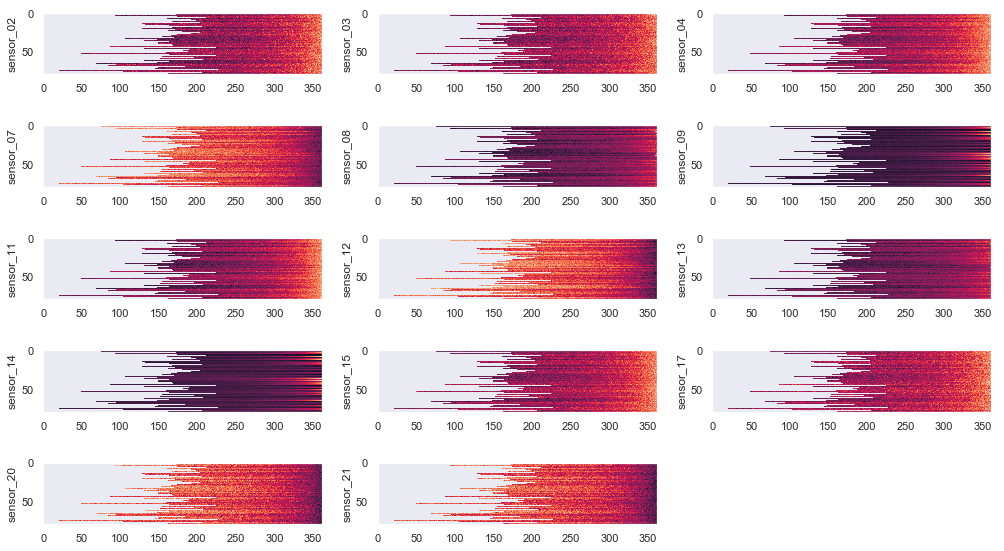

In [38]:
cols_features = [c for c in df_n_train.columns if c.startswith('o') or c.startswith('s')]

PlottingHelpers.plot_imshow(df_n_train, resample=False)


In [39]:
X_train = df_n_train[cols_features].values
y_train = df_n_train['RUL'].values

X_test = df_n_test[cols_features].values
y_test = df_n_test['RUL'].values

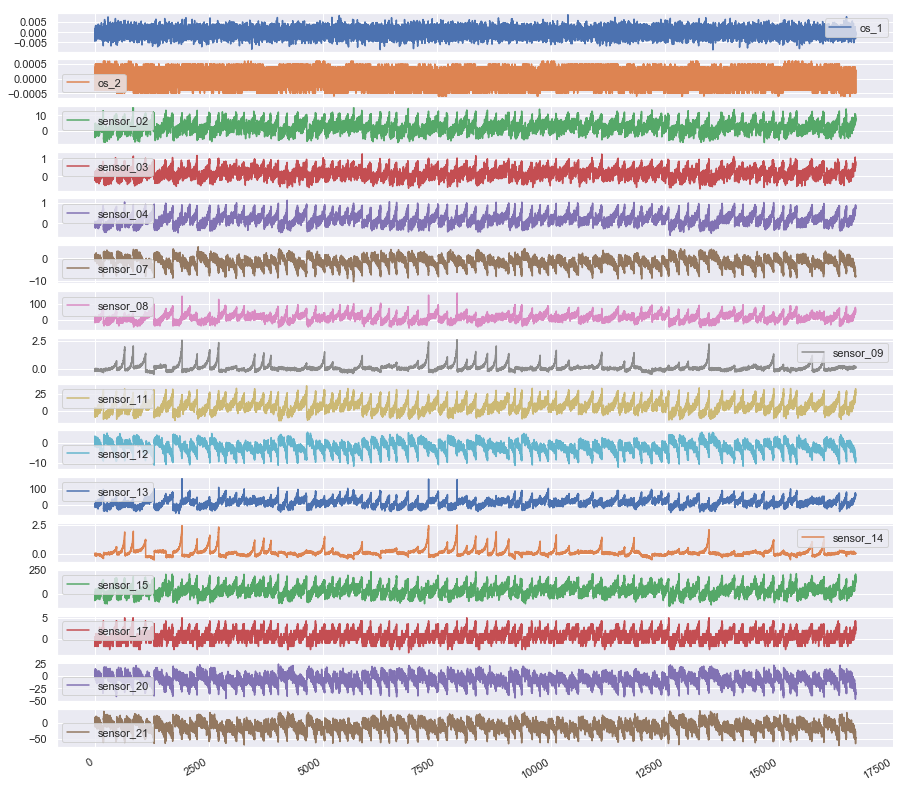

In [40]:
t = pd.DataFrame(X_train, columns=cols_features).plot(subplots=True, figsize=(15, 15))

## Do a simple support vector machine based regression based on all training data

In [97]:
res = {}

In [98]:
cols_features = [c for c in df_n_train.columns if c.startswith('s')]
print(cols_features)
exclude = [ 'sensor_{}'.format(n) for n in ['08', '09', '11', '12', '13', '14'] ]
print(exclude)
cols_features = [c for c in df_n_train.columns if c.startswith('s') and c not in exclude]
print(cols_features)

['sensor_02', 'sensor_03', 'sensor_04', 'sensor_07', 'sensor_08', 'sensor_09', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_17', 'sensor_20', 'sensor_21']
['sensor_08', 'sensor_09', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14']
['sensor_02', 'sensor_03', 'sensor_04', 'sensor_07', 'sensor_15', 'sensor_17', 'sensor_20', 'sensor_21']


In [99]:
cols_features = [c for c in df_n_train.columns if c.startswith('s')]

X_train = df_n_train[cols_features].values
y_train = df_n_train['RUL'].values

X_test = df_n_test[cols_features].values
y_test = df_n_test['RUL'].values

print(X_train.shape)
mdl = sk.pipeline.Pipeline([
    ('scaler', sk.preprocessing.MinMaxScaler()),
    ('regression', sk.svm.SVR(gamma='scale')),
])

scoring = sk.metrics.mean_squared_error

y_cv = sk.model_selection.cross_val_predict(
    mdl,
    X_train,
    y_train,
    cv=3,
)

mdl.fit(X_train, y_train)
y_test_p = mdl.predict(X_test)


scoring = sk.metrics.mean_squared_error

print("cv test mse: %s" % scoring(y_cv, y_train))
print("testing units mse: %s" % scoring(y_test_p, y_test))

res['all_full'] = {
    'train_cv': y_cv - y_train,
    'test_cv': y_test_p - y_test
}

# Exclude the channels 14 and 9 since they are not generally falling or raising, and the channels 

exclude = [ 'sensor_{}'.format(n) for n in ['08', '09', '11', '12', '13', '14'] ]
cols_features = [c for c in df_n_train.columns if c.startswith('s') and c not in exclude]

X_train = df_n_train[cols_features].values
y_train = df_n_train['RUL'].values

X_test = df_n_train[cols_features].values
y_test = df_n_train['RUL'].values

print(X_train.shape)

mdl = sk.pipeline.Pipeline([
    ('scaler', sk.preprocessing.MinMaxScaler()),
    ('regression', sk.svm.SVR(gamma='scale')),
])

scoring = sk.metrics.mean_squared_error

y_cv = sk.model_selection.cross_val_predict(
    mdl,
    X_train,
    y_train,
    cv=3,
)

mdl.fit(X_train, y_train)
y_test_p = mdl.predict(X_test)

scoring = sk.metrics.mean_squared_error

print("cv test mse: %s" % scoring(y_cv, y_train))
print("testing units mse: %s" % scoring(y_test_p, y_test))

res['all_red'] = {
    'train_cv': y_cv - y_train,
    'test_cv': y_test_p - y_test
}

(16680, 14)
cv test mse: 2078.6054516507456
testing units mse: 1534.02638019874
(16680, 8)
cv test mse: 2303.944938856938
testing units mse: 2224.291946512543


C:\Users\GLA_A\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


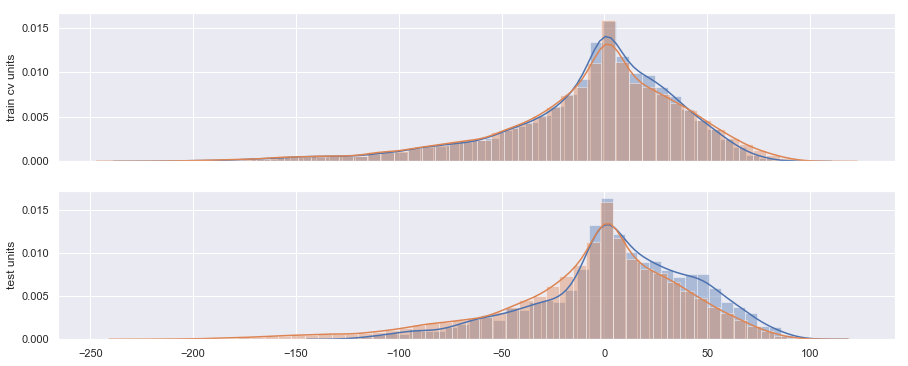

In [100]:
fig, axes = plt.subplots(2, 1, figsize=(15, 6), sharex=True)
axes = axes.flatten()

for name, dc2 in res.items():
    sns.distplot(dc2['train_cv'], ax=axes[0])
    sns.distplot(dc2['test_cv'], ax=axes[1])
    
lbl = axes[1].set_ylabel('test units')
lbl = axes[0].set_ylabel('train cv units')

the model(s) seems to converge, but the error distributions do not look very good, considering the fact, that some predictions are nearly 100 cycles off, while some units just have a life cylcle of about 125 cycles.
Lets try to simply average the data over a few cycles before using it for regression.



C:\Users\GLA_A\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\GLA_A\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\GLA_A\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead

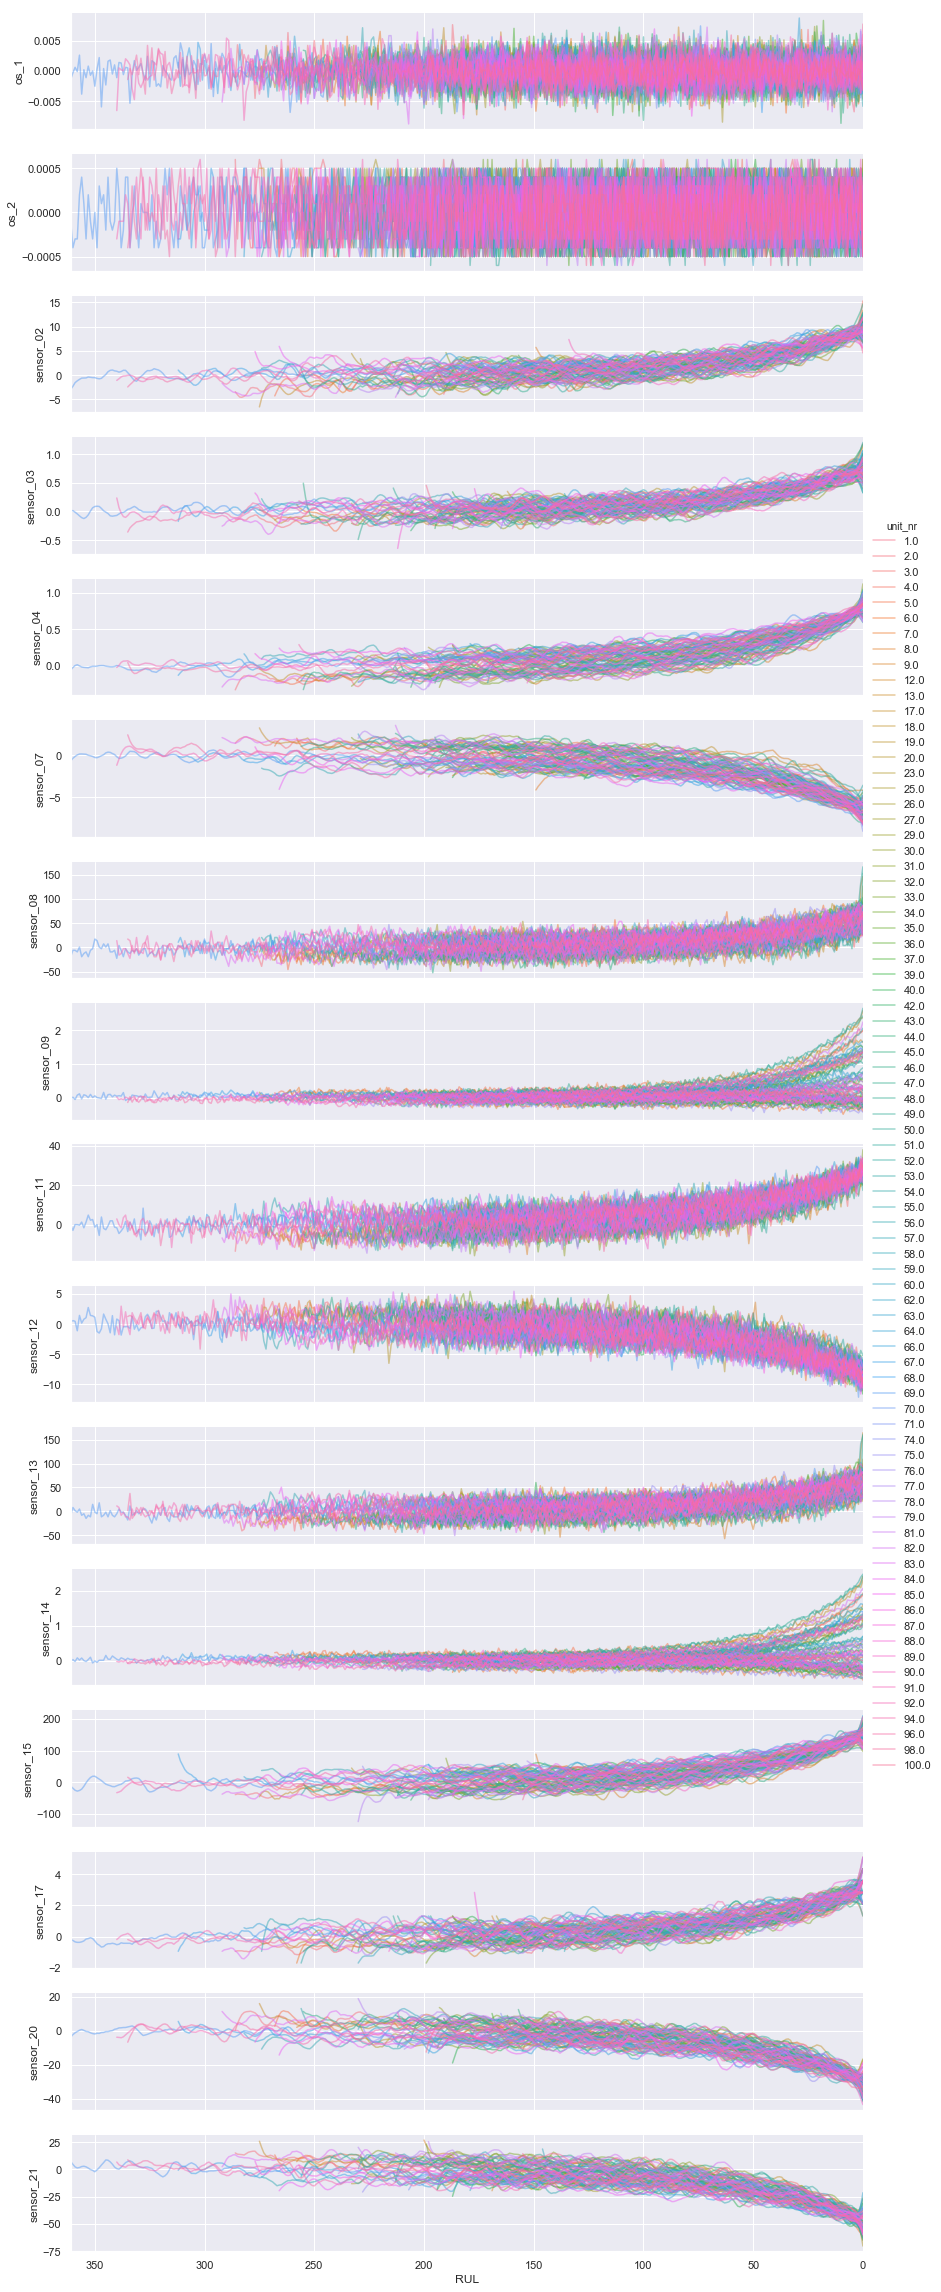

In [101]:
filtfilt = ProcessingHelpers.apply_filtfilt_by_unit
cols_tmp = cols_features + ['unit_nr']

b = np.ones(5) / 5.0
df_n_train_avg = df_n_train.copy()
df_n_train_avg[cols_tmp] = filtfilt(df_n_train[cols_tmp], b)

PlottingHelpers.plot_grouped_by_RUL(df_n_train_avg)

In [103]:
cols_features = [c for c in df_n_train.columns if c.startswith('s')]

X_train = df_n_train_avg[cols_features].values
y_train = df_n_train_avg['RUL'].values

X_test = df_n_train_avg[cols_features].values
y_test = df_n_train_avg['RUL'].values

print(X_train.shape)
mdl = sk.pipeline.Pipeline([
    ('scaler', sk.preprocessing.MinMaxScaler()),
    ('regression', sk.svm.SVR(gamma='scale')),
])

scoring = sk.metrics.mean_squared_error

y_cv = sk.model_selection.cross_val_predict(
    mdl,
    X_train,
    y_train,
    cv=3,
)

mdl.fit(X_train, y_train)
y_test_p = mdl.predict(X_test)


scoring = sk.metrics.mean_squared_error

print("cv test mse: %s" % scoring(y_cv, y_train))
print("testing units mse: %s" % scoring(y_test_p, y_test))

res['avg_full'] = {
    'train_cv': y_cv - y_train,
    'test_cv': y_test_p - y_test
}

# Exclude the channels 14 and 9 since they are not generally falling or raising, and the channels 

exclude = [ 'sensor_{}'.format(n) for n in ['08', '09', '11', '12', '13', '14'] ]
cols_features = [c for c in df_n_train.columns if c.startswith('s') and c not in exclude]

X_train = df_n_train_avg[cols_features].values
y_train = df_n_train_avg['RUL'].values

X_test = df_n_train_avg[cols_features].values
y_test = df_n_train_avg['RUL'].values


print(X_train.shape)

mdl = sk.pipeline.Pipeline([
    ('scaler', sk.preprocessing.MinMaxScaler()),
    ('regression', sk.svm.SVR(gamma='scale')),
])

scoring = sk.metrics.mean_squared_error

y_cv = sk.model_selection.cross_val_predict(
    mdl,
    X_train,
    y_train,
    cv=3,
)

mdl.fit(X_train, y_train)
y_test_p = mdl.predict(X_test)

scoring = sk.metrics.mean_squared_error

print("cv test mse: %s" % scoring(y_cv, y_train))
print("testing units mse: %s" % scoring(y_test_p, y_test))

res['avg_red'] = {
    'train_cv': y_cv - y_train,
    'test_cv': y_test_p - y_test
}

(16680, 14)
cv test mse: 2001.3638277647265
testing units mse: 1887.5608932720108
(16680, 8)
cv test mse: 2173.1937743405933
testing units mse: 2063.0935513055747


In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(15, 6), sharex=True)
axes = axes.flatten()

for name, dc2 in res.items():
    sns.distplot(dc2['train_cv'], ax=axes[0])
    sns.distplot(dc2['test_cv'], ax=axes[1])
    
lbl = axes[1].set_ylabel('test units')
lbl = axes[0].set_ylabel('train cv units')

That does look like the model is converging, but the results are not very well. Lets take a look at a few more regression models.

## Test some more out of the box regression models and plot the results

In [ ]:
models = {
    'lr': sk.linear_model.LinearRegression(),
    'lasso': sk.linear_model.Lasso(alpha=.1),
    'Bridge': sk.linear_model.BayesianRidge(),
    #'Kridge': sk.kernel_ridge.KernelRidge(),
    'ridge': sk.linear_model.Ridge(),
    #'GBR': sk.ensemble.GradientBoostingRegressor(),
    'svr': sk.svm.SVR(gamma='scale')
}

scoring = sk.metrics.mean_squared_error
res = {}
for name, clf in models.items():
    mdl = sk.pipeline.Pipeline([
        ('scaler', sk.preprocessing.MinMaxScaler()),
        ('regression', models[name]),
    ])
    
    y_cv = sk.model_selection.cross_val_predict(
        mdl,
        X_train,
        y_train,
        cv=3)
    
    res[name] = {
        'mdl': mdl,
        'y_cv': y_cv
    }
    
fig, axes = plt.subplots(len(models), 1, figsize=(15,12), sharex=True)
axes = axes.flatten()
for ax, name in zip(axes, res.keys()):
    s = "{}: cv test mse: {}".format(name, -scoring(y_cv, y_train))
    y_cv = res[name]['y_cv']
    sns.distplot(y_cv - y_train, ax=ax)
    #ax.set_title(s)
    

## Generate some more regression models as well as distributions to tune the parameters of those

In [ ]:
regressors = {
    "SVM": sk.svm.SVR(gamma='scale'),
    "Nearest Neighbor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Neural Net": MLPRegressor(),
    "Gaussian Process": GaussianProcessRegressor(1.0 * RBF(1.0)),
}

models = {
    'lr': sk.linear_model.LinearRegression(),
    'lasso': sk.linear_model.Lasso(alpha=.1),
    'Bridge': sk.linear_model.BayesianRidge(),
    #'Kridge': sk.kernel_ridge.KernelRidge(),
    'ridge': sk.linear_model.Ridge(),
    #'GBR': sk.ensemble.GradientBoostingRegressor(),
    'svr': sk.svm.SVR(gamma='scale')
}

optimizers = {
        "SVM": {
            'C': expon(scale=100),
            'gamma': expon(scale=.1),
            'kernel': ['linear', 'rbf'],
            "shrinking": [True, False],
        },
        "Nearest Neighbor": {
            "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
            "n_neighbors": randint(1, 20),
            "weights": ["uniform", "distance"],
            "leaf_size": randint(5, 50)
        },
        "Decision Tree": {
            "min_samples_leaf": randint(1, 11),
            "criterion": ["gini", "entropy"],
            "max_depth": randint(1, 1000),
        },
        "Random Forest": {
            "min_samples_leaf": randint(1, 11),
            "bootstrap": [True, False],
            "criterion": ["gini", "entropy"],
            "max_depth": randint(1, 5),
            "warm_start": [True, False]
        },
        "Gaussian Process": None,
        "Neural Net": {
            "activation": ["identity", "logistic", "tanh", "relu"],
            "solver": ["lbfgs", "sgd", "adam"],
            "learning_rate": ["constant", "invscaling", "adaptive"],
            "hidden_layer_sizes": randint(1, 99),
            "alpha": uniform(0.000001, 2),
            "power_t": uniform(0.1, .9),
            "momentum": uniform(0.0, 1.0)
        },
        "AdaBoost": None,
        "Naive Bayes": None,
    }

In [ ]:
exclude = [ 'sensor_'.format(n) for n in ['11', '12', '13', '14'] ]
cols_features = [c for c in df_n_train.columns if c.startswith('s') and c not in exclude]

print(cols_features)

In [ ]:
X_train = df_n_train[cols_features].values
n_jobs = 1
validator = StratifiedKFold(5, random_state=0)

scoring = sk.metrics.mean_squared_error
res = {}
lock = True
if lock:
    print('not performing optimization, because it takes so long. make sure to set lock to '
          + 'False if you are really sure you want to run it')
else:
    for name, mdl in regressors.items():

        # use the parameters given in RandomizedSearchCV
        rscv = RandomizedSearchCV(mdl, optimizers[name],
                                       n_iter=125, n_jobs=n_jobs,
                                       cv=validator, scoring='neg_mean_squared_error',
                                       refit=True, random_state=0
                                       )

        # find the best fitting classifier
        rscv.fit(X_train, y_train)
        clf = self.rscv.best_estimator_


        y_cv = sk.model_selection.cross_val_predict(
            mdl,
            X_train,
            y_train,
            cv=3)

        res[name] = {
            'mdl': mdl,
            'y_cv': y_cv
        }

    fig, axes = plt.subplots(len(models), 1, figsize=(15,12))
    axes = axes.flatten()
    for ax, name in zip(axes, res.keys()):
        s = "{}: cv test mse: {}".format(name, -scoring(y_cv, y_train))
        y_cv = res[name]['y_cv']
        sns.distplot(y_cv - y_train, ax=ax)
        #ax.set_title(s)
